## 1. Import bibliotek i konfiguracja

In [3]:
# Instalacja wymaganych bibliotek (odkomentuj jeśli potrzebne)
!pip install neurokit2 pandas numpy scikit-learn matplotlib seaborn xgboost tqdm

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 708.4/708.4 kB 14.7 MB/s  0:00:00


In [4]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Przetwarzanie sygnałów
import neurokit2 as nk
from scipy import signal
from scipy.stats import skew, kurtosis

# Machine Learning
from sklearn.model_selection import LeaveOneGroupOut, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.pipeline import Pipeline

# Ustawienia wizualizacji
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

print("✅ Wszystkie biblioteki załadowane pomyślnie!")
print(f"NeuroKit2 version: {nk.__version__}")

✅ Wszystkie biblioteki załadowane pomyślnie!
NeuroKit2 version: 0.2.12


In [5]:
# Ścieżka do danych WESAD
DATA_PATH = Path("/home/milosz/Desktop/studia/afektywna/archive/WESAD")

# Lista dostępnych uczestników
SUBJECTS = ['S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'S13', 'S14', 'S15', 'S16', 'S17']

# Parametry sygnałów z Empatica E4
SAMPLING_RATES = {
    'BVP': 64,    # Hz
    'EDA': 4,     # Hz
    'TEMP': 4,    # Hz
    'ACC': 32     # Hz
}

# Mapowanie etykiet
LABEL_MAPPING = {
    0: 'not_defined',
    1: 'baseline',
    2: 'stress',
    3: 'amusement',
    4: 'meditation'
}

# Parametry okien czasowych (w sekundach)
WINDOW_SIZE = 60  # 60 sekund
WINDOW_SHIFT = 30  # 50% overlap

print(f"📁 Ścieżka do danych: {DATA_PATH}")
print(f"👥 Liczba uczestników: {len(SUBJECTS)}")

📁 Ścieżka do danych: /home/milosz/Desktop/studia/afektywna/archive/WESAD
👥 Liczba uczestników: 15


## 2. Wczytywanie danych

In [6]:
def load_subject_data(subject_id: str) -> dict:
    """
    Wczytuje dane pojedynczego uczestnika z pliku .pkl
    
    Returns:
        dict z kluczami: 'signal' (dane z wrist i chest), 'label', 'subject'
    """
    file_path = DATA_PATH / subject_id / f"{subject_id}.pkl"
    
    with open(file_path, 'rb') as f:
        data = pickle.load(f, encoding='latin1')
    
    return data

# Test wczytywania
sample_data = load_subject_data('S2')
print("🔑 Klucze w danych:", sample_data.keys())
print("\n📊 Sygnały z nadgarstka (wrist):")
for key, value in sample_data['signal']['wrist'].items():
    print(f"   {key}: shape = {value.shape}")

print(f"\n🏷️ Etykiety: shape = {sample_data['label'].shape}")
print(f"   Unikalne wartości: {np.unique(sample_data['label'])}")

🔑 Klucze w danych: dict_keys(['signal', 'label', 'subject'])

📊 Sygnały z nadgarstka (wrist):
   ACC: shape = (194528, 3)
   BVP: shape = (389056, 1)
   EDA: shape = (24316, 1)
   TEMP: shape = (24316, 1)

🏷️ Etykiety: shape = (4255300,)
   Unikalne wartości: [0 1 2 3 4 6 7]


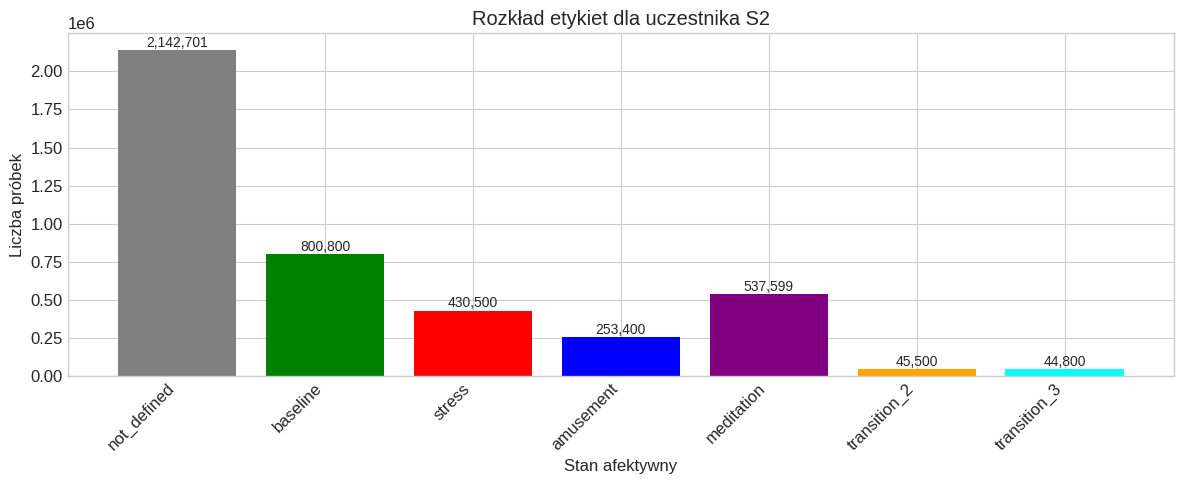

In [8]:
# Sprawdzenie rozkładu etykiet
labels = sample_data['label'].flatten()
label_counts = pd.Series(labels).value_counts().sort_index()

# Rozszerzone mapowanie (WESAD ma etykiety 0-7)
LABEL_MAPPING_FULL = {
    0: 'not_defined',
    1: 'baseline',
    2: 'stress',
    3: 'amusement',
    4: 'meditation',
    5: 'transition_1',
    6: 'transition_2',
    7: 'transition_3'
}

fig, ax = plt.subplots(figsize=(12, 5))
colors = ['gray', 'green', 'red', 'blue', 'purple', 'orange', 'cyan', 'pink']
label_names = [LABEL_MAPPING_FULL.get(i, f'unknown_{i}') for i in label_counts.index]

bars = ax.bar(label_names, label_counts.values, color=colors[:len(label_counts)])
ax.set_xlabel('Stan afektywny')
ax.set_ylabel('Liczba próbek')
ax.set_title('Rozkład etykiet dla uczestnika S2')
plt.xticks(rotation=45, ha='right')

for bar, count in zip(bars, label_counts.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1000, 
            f'{count:,}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

## 3. Wizualizacja sygnałów

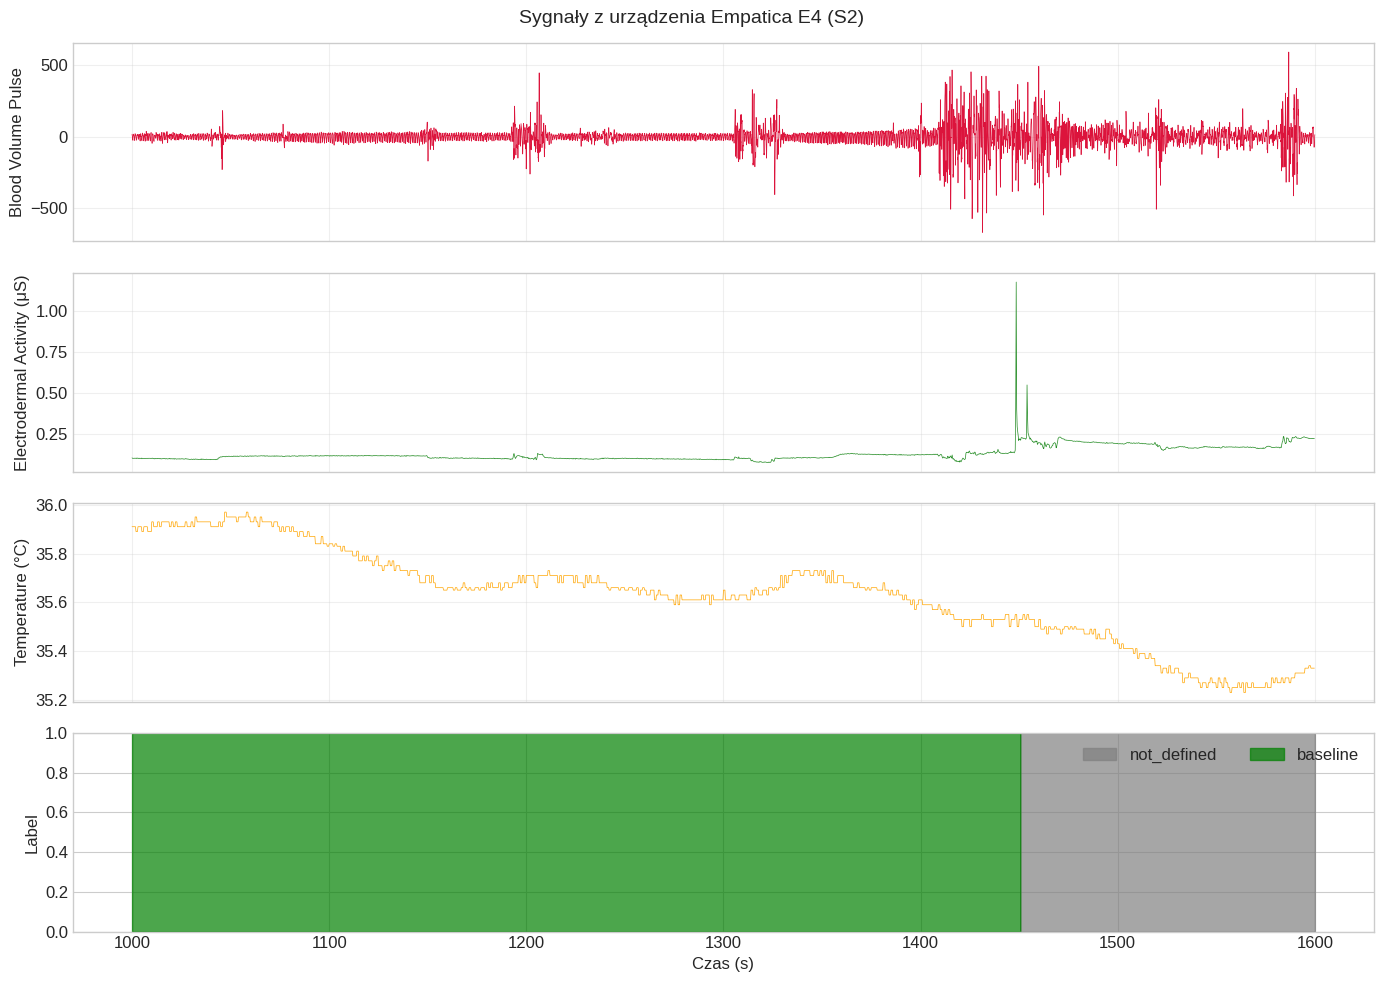

In [9]:
def plot_signals_with_labels(data: dict, start_sec: int = 0, duration_sec: int = 300):
    """
    Wizualizacja sygnałów z nadgarstka wraz z etykietami stanów
    """
    fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)
    
    # Etykiety (700 Hz - sampling rate z chest)
    labels = data['label'].flatten()
    chest_sr = 700
    
    # Zakresy dla każdego sygnału
    signals_config = [
        ('BVP', 64, 'Blood Volume Pulse', 'crimson'),
        ('EDA', 4, 'Electrodermal Activity (μS)', 'forestgreen'),
        ('TEMP', 4, 'Temperature (°C)', 'orange'),
    ]
    
    for idx, (sig_name, sr, title, color) in enumerate(signals_config):
        sig = data['signal']['wrist'][sig_name].flatten()
        start_idx = start_sec * sr
        end_idx = min((start_sec + duration_sec) * sr, len(sig))
        
        time = np.arange(start_idx, end_idx) / sr
        axes[idx].plot(time, sig[start_idx:end_idx], color=color, linewidth=0.5)
        axes[idx].set_ylabel(title)
        axes[idx].grid(True, alpha=0.3)
    
    # Etykiety
    label_start = start_sec * chest_sr
    label_end = min((start_sec + duration_sec) * chest_sr, len(labels))
    time_labels = np.arange(label_start, label_end) / chest_sr
    
    label_colors = {0: 'gray', 1: 'green', 2: 'red', 3: 'blue', 4: 'purple'}
    for label_val in np.unique(labels[label_start:label_end]):
        mask = labels[label_start:label_end] == label_val
        axes[3].fill_between(time_labels, 0, 1, where=mask, 
                            color=label_colors[label_val], alpha=0.7,
                            label=LABEL_MAPPING[label_val])
    
    axes[3].set_ylabel('Label')
    axes[3].set_xlabel('Czas (s)')
    axes[3].legend(loc='upper right', ncol=5)
    axes[3].set_ylim(0, 1)
    
    plt.suptitle(f'Sygnały z urządzenia Empatica E4 (S2)', fontsize=14)
    plt.tight_layout()
    plt.show()

# Wizualizacja 5 minut danych
plot_signals_with_labels(sample_data, start_sec=1000, duration_sec=600)

## 4. Ekstrakcja cech (Feature Engineering)

### Kluczowy etap projektu!
Używamy biblioteki **NeuroKit2** do automatycznej ekstrakcji cech z sygnałów fizjologicznych.

In [10]:
def extract_eda_features(eda_signal: np.ndarray, sampling_rate: int = 4) -> dict:
    """
    Ekstrakcja cech z sygnału EDA (Electrodermal Activity)
    
    Cechy:
    - Statystyczne: mean, std, min, max, range
    - Phasic/Tonic decomposition (NeuroKit2)
    - SCR peaks (Skin Conductance Responses)
    """
    features = {}
    
    try:
        # Podstawowe statystyki
        features['eda_mean'] = np.mean(eda_signal)
        features['eda_std'] = np.std(eda_signal)
        features['eda_min'] = np.min(eda_signal)
        features['eda_max'] = np.max(eda_signal)
        features['eda_range'] = features['eda_max'] - features['eda_min']
        features['eda_slope'] = (eda_signal[-1] - eda_signal[0]) / len(eda_signal)
        
        # Przetwarzanie EDA z NeuroKit2
        if len(eda_signal) > sampling_rate * 2:  # minimum 2 sekundy
            eda_processed = nk.eda_process(eda_signal, sampling_rate=sampling_rate)
            eda_df = eda_processed[0]
            
            # Składowa toniczna (baseline)
            if 'EDA_Tonic' in eda_df.columns:
                features['eda_tonic_mean'] = eda_df['EDA_Tonic'].mean()
                features['eda_tonic_std'] = eda_df['EDA_Tonic'].std()
            
            # Składowa fazowa (reakcje)
            if 'EDA_Phasic' in eda_df.columns:
                features['eda_phasic_mean'] = eda_df['EDA_Phasic'].mean()
                features['eda_phasic_std'] = eda_df['EDA_Phasic'].std()
                features['eda_phasic_max'] = eda_df['EDA_Phasic'].max()
            
            # Liczba pików SCR (Skin Conductance Response)
            if 'SCR_Peaks' in eda_df.columns:
                features['scr_peaks_count'] = eda_df['SCR_Peaks'].sum()
                features['scr_peaks_rate'] = features['scr_peaks_count'] / (len(eda_signal) / sampling_rate / 60)  # per minute
    
    except Exception as e:
        # Fallback na podstawowe statystyki
        features['eda_mean'] = np.mean(eda_signal)
        features['eda_std'] = np.std(eda_signal)
    
    return features


def extract_bvp_features(bvp_signal: np.ndarray, sampling_rate: int = 64) -> dict:
    """
    Ekstrakcja cech z sygnału BVP (Blood Volume Pulse)
    
    Cechy:
    - HR (Heart Rate) statystyki
    - HRV (Heart Rate Variability) - kluczowe dla stresu!
    """
    features = {}
    
    try:
        # Podstawowe statystyki BVP
        features['bvp_mean'] = np.mean(bvp_signal)
        features['bvp_std'] = np.std(bvp_signal)
        
        if len(bvp_signal) > sampling_rate * 5:  # minimum 5 sekund
            # Przetwarzanie PPG z NeuroKit2
            ppg_processed = nk.ppg_process(bvp_signal, sampling_rate=sampling_rate)
            ppg_df = ppg_processed[0]
            
            # Heart Rate
            if 'PPG_Rate' in ppg_df.columns:
                hr = ppg_df['PPG_Rate'].dropna()
                if len(hr) > 0:
                    features['hr_mean'] = hr.mean()
                    features['hr_std'] = hr.std()
                    features['hr_min'] = hr.min()
                    features['hr_max'] = hr.max()
                    features['hr_range'] = features['hr_max'] - features['hr_min']
            
            # HRV analysis
            peaks = ppg_df[ppg_df['PPG_Peaks'] == 1].index.values
            if len(peaks) > 2:
                # RR intervals (w ms)
                rr_intervals = np.diff(peaks) / sampling_rate * 1000
                
                if len(rr_intervals) > 1:
                    # Time-domain HRV
                    features['hrv_rmssd'] = np.sqrt(np.mean(np.diff(rr_intervals)**2))
                    features['hrv_sdnn'] = np.std(rr_intervals)
                    features['hrv_mean_rr'] = np.mean(rr_intervals)
                    features['hrv_pnn50'] = np.sum(np.abs(np.diff(rr_intervals)) > 50) / len(rr_intervals) * 100
    
    except Exception as e:
        # Fallback
        features['bvp_mean'] = np.mean(bvp_signal)
        features['bvp_std'] = np.std(bvp_signal)
    
    return features


def extract_temp_features(temp_signal: np.ndarray) -> dict:
    """
    Ekstrakcja cech z sygnału temperatury skóry
    """
    features = {}
    
    features['temp_mean'] = np.mean(temp_signal)
    features['temp_std'] = np.std(temp_signal)
    features['temp_min'] = np.min(temp_signal)
    features['temp_max'] = np.max(temp_signal)
    features['temp_range'] = features['temp_max'] - features['temp_min']
    features['temp_slope'] = (temp_signal[-1] - temp_signal[0]) / len(temp_signal) if len(temp_signal) > 1 else 0
    
    return features


print("✅ Funkcje ekstrakcji cech zdefiniowane!")

✅ Funkcje ekstrakcji cech zdefiniowane!


In [11]:
def extract_window_features(data: dict, window_start_idx: int, window_size_sec: int = 60) -> dict:
    """
    Ekstrakcja cech dla pojedynczego okna czasowego
    
    Args:
        data: słownik z danymi uczestnika
        window_start_idx: indeks startowy w ramce etykiet (700 Hz)
        window_size_sec: rozmiar okna w sekundach
    
    Returns:
        dict z wszystkimi cechami dla okna
    """
    features = {}
    chest_sr = 700  # sampling rate etykiet
    
    # Oblicz indeksy dla każdego sygnału
    for sig_name, sig_sr in SAMPLING_RATES.items():
        if sig_name == 'ACC':
            continue  # pomijamy akcelerometr dla uproszczenia
            
        # Przeliczenie indeksów
        ratio = sig_sr / chest_sr
        sig_start = int(window_start_idx * ratio)
        sig_end = int((window_start_idx + window_size_sec * chest_sr) * ratio)
        
        # Pobierz fragment sygnału
        signal_data = data['signal']['wrist'][sig_name].flatten()
        sig_window = signal_data[sig_start:sig_end]
        
        if len(sig_window) < sig_sr:  # za krótki sygnał
            continue
        
        # Ekstrakcja cech w zależności od typu sygnału
        if sig_name == 'EDA':
            features.update(extract_eda_features(sig_window, sig_sr))
        elif sig_name == 'BVP':
            features.update(extract_bvp_features(sig_window, sig_sr))
        elif sig_name == 'TEMP':
            features.update(extract_temp_features(sig_window))
    
    return features


def get_majority_label(labels: np.ndarray, window_start: int, window_size_sec: int, chest_sr: int = 700) -> int:
    """
    Zwraca najczęstszą etykietę w oknie czasowym
    """
    window_end = window_start + window_size_sec * chest_sr
    window_labels = labels[window_start:window_end]
    
    # Usuń etykiety 0 (nie zdefiniowane)
    valid_labels = window_labels[window_labels > 0]
    
    if len(valid_labels) == 0:
        return 0
    
    # Zwróć najczęstszą
    unique, counts = np.unique(valid_labels, return_counts=True)
    return unique[np.argmax(counts)]


print("✅ Funkcje przetwarzania okien zdefiniowane!")

✅ Funkcje przetwarzania okien zdefiniowane!


In [12]:
def process_subject(subject_id: str, window_size: int = 60, window_shift: int = 30) -> pd.DataFrame:
    """
    Przetwarza dane jednego uczestnika i zwraca DataFrame z cechami
    
    Args:
        subject_id: identyfikator uczestnika (np. 'S2')
        window_size: rozmiar okna w sekundach
        window_shift: przesunięcie okna w sekundach
    
    Returns:
        pd.DataFrame z cechami i etykietami
    """
    data = load_subject_data(subject_id)
    labels = data['label'].flatten()
    
    chest_sr = 700
    total_samples = len(labels)
    
    all_features = []
    
    # Iteracja po oknach
    window_start = 0
    while window_start + window_size * chest_sr < total_samples:
        # Pobierz etykietę dla okna
        label = get_majority_label(labels, window_start, window_size, chest_sr)
        
        # Pomijamy okna bez zdefiniowanej etykiety
        if label == 0:
            window_start += window_shift * chest_sr
            continue
        
        # Ekstrakcja cech
        features = extract_window_features(data, window_start, window_size)
        
        if features:  # jeśli udało się wyekstrahować cechy
            features['label'] = label
            features['subject'] = subject_id
            features['window_start'] = window_start / chest_sr
            all_features.append(features)
        
        window_start += window_shift * chest_sr
    
    return pd.DataFrame(all_features)


# Test na jednym uczestniku
print("🔄 Przetwarzanie uczestnika S2...")
df_test = process_subject('S2', window_size=60, window_shift=30)
print(f"✅ Wyekstrahowano {len(df_test)} okien z {df_test.shape[1]} cechami")
print(f"\n📊 Rozkład etykiet:")
print(df_test['label'].value_counts())

🔄 Przetwarzanie uczestnika S2...
✅ Wyekstrahowano 114 okien z 33 cechami

📊 Rozkład etykiet:
label
1    40
4    29
2    23
3    14
6     4
7     4
Name: count, dtype: int64
✅ Wyekstrahowano 114 okien z 33 cechami

📊 Rozkład etykiet:
label
1    40
4    29
2    23
3    14
6     4
7     4
Name: count, dtype: int64


In [13]:
# Podgląd wyekstrahowanych cech
df_test.head(10)

,bvp_mean,bvp_std,hr_mean,hr_std,hr_min,hr_max,hr_range,hrv_rmssd,hrv_sdnn,hrv_mean_rr,...,scr_peaks_rate,temp_mean,temp_std,temp_min,temp_max,temp_range,temp_slope,label,subject,window_start
0,-1.116656,107.844014,76.731367,24.058433,32.542373,153.600000,121.057627,381.317055,292.339708,803.724315,...,16.0,35.809833,0.017841,35.77,35.84,0.07,0.000083,1,S2,270.0
1,0.068036,123.643504,79.061015,26.091717,39.183673,192.000000,152.816327,375.408878,273.936549,779.166667,...,18.0,35.810000,0.022730,35.75,35.87,0.12,-0.000333,1,S2,300.0
2,-0.020909,98.121144,75.944525,22.831835,32.820513,174.545455,141.724942,345.854511,260.288582,805.864726,...,11.0,35.759000,0.051501,35.66,35.87,0.21,-0.000417,1,S2,330.0
3,0.175719,44.970133,76.491343,22.927962,34.594595,192.000000,157.405405,320.714517,238.569134,802.011986,...,8.0,35.710000,0.026331,35.66,35.77,0.11,0.000000,1,S2,360.0
4,-0.281927,40.347788,77.602864,23.307992,34.594595,192.000000,157.405405,284.411195,231.679781,785.625000,...,11.0,35.727667,0.032576,35.66,35.79,0.13,0.000333,1,S2,390.0
5,-0.917495,73.254755,77.133152,21.820410,38.019802,192.000000,153.980198,232.885186,202.444265,787.708333,...,11.0,35.784667,0.039894,35.71,35.87,0.16,0.000458,1,S2,420.0
6,-0.009320,92.372939,76.445277,22.198468,37.647059,192.000000,154.352941,322.714070,245.721603,802.576014,...,14.0,35.831833,0.023699,35.79,35.89,0.10,0.000083,1,S2,450.0
7,0.916789,67.506580,77.397928,18.432388,46.829268,182.857143,136.027875,279.065512,187.558324,789.375000,...,9.0,35.820833,0.029905,35.77,35.89,0.12,-0.000208,1,S2,480.0
8,-0.018612,25.716487,75.452297,14.633959,52.602740,153.600000,100.997260,170.139996,143.607699,800.299658,...,6.0,35.794000,0.015406,35.77,35.83,0.06,-0.000083,1,S2,510.0
9,-0.134531,20.520690,73.237316,9.770538,52.602740,142.222222,89.619482,150.241621,108.961309,822.183099,...,39.0,35.818333,0.033024,35.77,35.89,0.12,0.000417,1,S2,540.0


## 5. Przetwarzanie wszystkich uczestników

In [14]:
# Przetwarzanie wszystkich uczestników
all_dataframes = []

print("🔄 Przetwarzanie wszystkich uczestników...\n")

for subject in tqdm(SUBJECTS, desc="Participants"):
    try:
        df_subject = process_subject(subject, window_size=WINDOW_SIZE, window_shift=WINDOW_SHIFT)
        all_dataframes.append(df_subject)
        print(f"   {subject}: {len(df_subject)} okien")
    except Exception as e:
        print(f"   ❌ {subject}: Błąd - {e}")

# Połączenie wszystkich danych
df_all = pd.concat(all_dataframes, ignore_index=True)
print(f"\n✅ Łącznie: {len(df_all)} okien z {df_all.shape[1]} kolumn")

🔄 Przetwarzanie wszystkich uczestników...



Participants:   7%|▋         | 1/15 [00:08<01:58,  8.48s/it]

   S2: 114 okien


Participants:  13%|█▎        | 2/15 [00:17<01:51,  8.60s/it]

   S3: 122 okien


Participants:  20%|██        | 3/15 [00:27<01:50,  9.19s/it]

   S4: 120 okien


Participants:  27%|██▋       | 4/15 [00:36<01:43,  9.43s/it]

   S5: 119 okien


Participants:  33%|███▎      | 5/15 [00:46<01:33,  9.40s/it]

   S6: 119 okien


Participants:  40%|████      | 6/15 [00:55<01:23,  9.30s/it]

   S7: 118 okien


Participants:  47%|████▋     | 7/15 [01:05<01:15,  9.49s/it]

   S8: 120 okien


Participants:  53%|█████▎    | 8/15 [01:15<01:07,  9.65s/it]

   S9: 121 okien


Participants:  60%|██████    | 9/15 [01:25<00:58,  9.81s/it]

   S10: 124 okien


Participants:  67%|██████▋   | 10/15 [01:34<00:47,  9.51s/it]

   S11: 121 okien


Participants:  73%|███████▎  | 11/15 [01:43<00:37,  9.40s/it]

   S13: 122 okien


Participants:  80%|████████  | 12/15 [01:54<00:29,  9.80s/it]

   S14: 121 okien


Participants:  87%|████████▋ | 13/15 [02:02<00:18,  9.39s/it]

   S15: 121 okien


Participants:  93%|█████████▎| 14/15 [02:11<00:09,  9.42s/it]

   S16: 121 okien


Participants: 100%|██████████| 15/15 [02:20<00:00,  9.40s/it]

   S17: 121 okien

✅ Łącznie: 1804 okien z 33 kolumn


In [15]:
# Podgląd danych
print("📊 Informacje o zbiorze danych:\n")
print(df_all.info())
print("\n" + "="*50)
print("\n📈 Statystyki opisowe:")
df_all.describe()

📊 Informacje o zbiorze danych:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1804 entries, 0 to 1803
Data columns (total 33 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bvp_mean         1804 non-null   float64
 1   bvp_std          1804 non-null   float64
 2   hr_mean          1804 non-null   float64
 3   hr_std           1804 non-null   float64
 4   hr_min           1804 non-null   float64
 5   hr_max           1804 non-null   float64
 6   hr_range         1804 non-null   float64
 7   hrv_rmssd        1804 non-null   float64
 8   hrv_sdnn         1804 non-null   float64
 9   hrv_mean_rr      1804 non-null   float64
 10  hrv_pnn50        1804 non-null   float64
 11  eda_mean         1804 non-null   float64
 12  eda_std          1804 non-null   float64
 13  eda_min          1804 non-null   float64
 14  eda_max          1804 non-null   float64
 15  eda_range        1804 non-null   float64
 16  eda_slope        1804 non-nu

,bvp_mean,bvp_std,hr_mean,hr_std,hr_min,hr_max,hr_range,hrv_rmssd,hrv_sdnn,hrv_mean_rr,...,scr_peaks_count,scr_peaks_rate,temp_mean,temp_std,temp_min,temp_max,temp_range,temp_slope,label,window_start
count,1804.000000,1804.000000,1804.000000,1804.000000,1804.000000,1804.000000,1804.000000,1804.000000,1804.000000,1804.000000,...,1804.000000,1804.000000,1804.000000,1804.000000,1804.000000,1804.000000,1804.000000,1804.000000,1804.000000,1804.000000
mean,-0.001159,47.548131,72.946978,18.605917,39.297189,158.479427,119.182239,363.539982,276.552206,854.515374,...,31.203437,31.203437,32.720901,0.032396,32.658631,32.782688,0.124058,-0.000013,2.642461,2591.607539
std,0.397650,39.261985,10.168866,7.245042,11.867691,31.901316,37.825567,408.010801,313.859418,129.301662,...,22.282838,22.282838,1.531112,0.027451,1.531238,1.533127,0.089896,0.000521,1.602547,1727.849008
min,-3.232135,2.416517,31.250455,2.378395,2.063407,68.571429,11.715254,19.906939,28.900863,456.395349,...,1.000000,1.000000,29.009167,0.008657,28.970000,29.050000,0.030000,-0.004000,1.000000,0.000000
25%,-0.090795,19.958364,66.918069,13.122463,33.684211,137.142857,96.265689,211.955218,160.184842,785.156250,...,11.000000,11.000000,31.670438,0.016342,31.610000,31.710000,0.070000,-0.000250,1.000000,1020.000000
50%,0.000845,36.694149,72.800883,18.400001,40.000000,166.956522,130.330963,295.482808,219.544863,836.707746,...,24.000000,24.000000,32.910250,0.023064,32.870000,32.950000,0.100000,-0.000083,2.000000,2370.000000
75%,0.094946,62.963491,77.730150,23.792464,46.829268,182.857143,147.896104,387.089339,289.044112,913.068096,...,54.000000,54.000000,33.824354,0.036204,33.750000,33.910000,0.140000,0.000167,4.000000,3990.000000
max,7.074826,294.638590,133.187940,45.220906,78.367347,192.000000,189.846326,7186.770760,4923.734937,2141.276042,...,82.000000,82.000000,35.928000,0.249220,35.890000,35.970000,0.960000,0.002875,7.000000,6870.000000


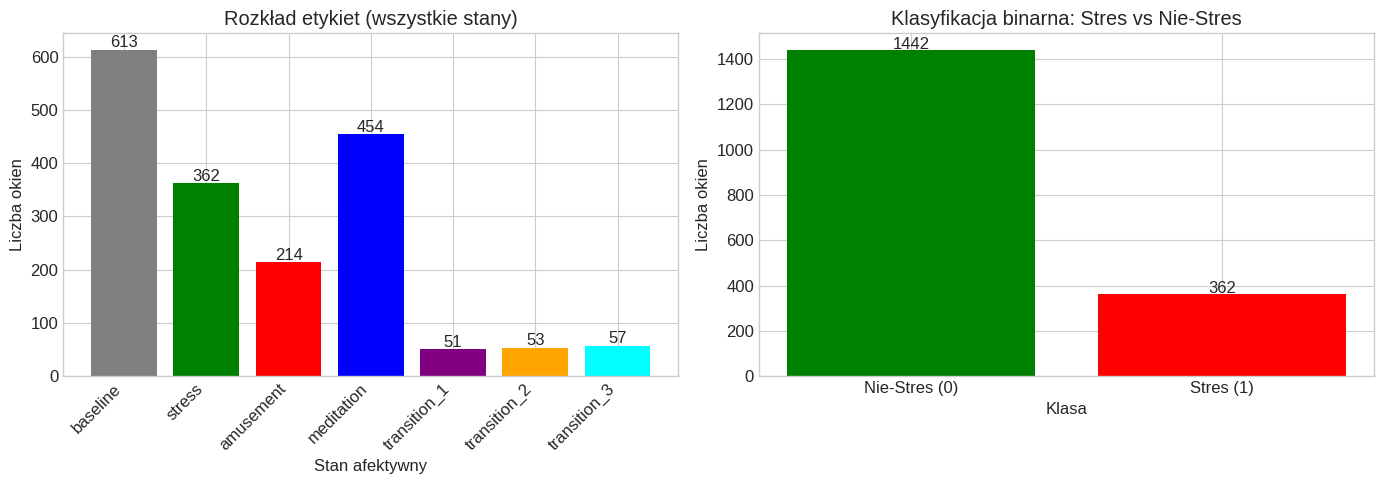


📊 Proporcja klas: 79.9% Nie-Stres, 20.1% Stres


In [17]:
# Rozkład etykiet
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Rozszerzone mapowanie dla wszystkich etykiet
LABEL_MAPPING_FULL = {
    0: 'not_defined',
    1: 'baseline',
    2: 'stress',
    3: 'amusement',
    4: 'meditation',
    5: 'transition_1',
    6: 'transition_2',
    7: 'transition_3'
}

# Wszystkie etykiety
label_counts = df_all['label'].value_counts().sort_index()
colors = ['gray', 'green', 'red', 'blue', 'purple', 'orange', 'cyan', 'pink']
labels_names = [LABEL_MAPPING_FULL.get(i, f'unknown_{i}') for i in label_counts.index]

axes[0].bar(labels_names, label_counts.values, color=colors[:len(label_counts)])
axes[0].set_title('Rozkład etykiet (wszystkie stany)')
axes[0].set_xlabel('Stan afektywny')
axes[0].set_ylabel('Liczba okien')
plt.sca(axes[0])
plt.xticks(rotation=45, ha='right')

for i, (name, count) in enumerate(zip(labels_names, label_counts.values)):
    axes[0].text(i, count + 5, str(count), ha='center')

# Klasyfikacja binarna: Stres vs Nie-Stres
df_all['is_stress'] = (df_all['label'] == 2).astype(int)
binary_counts = df_all['is_stress'].value_counts().sort_index()

axes[1].bar(['Nie-Stres (0)', 'Stres (1)'], binary_counts.values, color=['green', 'red'])
axes[1].set_title('Klasyfikacja binarna: Stres vs Nie-Stres')
axes[1].set_xlabel('Klasa')
axes[1].set_ylabel('Liczba okien')

for i, count in enumerate(binary_counts.values):
    axes[1].text(i, count + 5, str(count), ha='center')

plt.tight_layout()
plt.show()

print(f"\n📊 Proporcja klas: {binary_counts[0]/len(df_all)*100:.1f}% Nie-Stres, {binary_counts[1]/len(df_all)*100:.1f}% Stres")

## 6. Przygotowanie danych do modelowania

In [18]:
# Usunięcie kolumn niebędących cechami
feature_columns = [col for col in df_all.columns if col not in ['label', 'subject', 'window_start', 'is_stress']]

print(f"📋 Cechy używane do klasyfikacji ({len(feature_columns)}):")
for i, col in enumerate(feature_columns, 1):
    print(f"   {i:2d}. {col}")

📋 Cechy używane do klasyfikacji (30):
    1. bvp_mean
    2. bvp_std
    3. hr_mean
    4. hr_std
    5. hr_min
    6. hr_max
    7. hr_range
    8. hrv_rmssd
    9. hrv_sdnn
   10. hrv_mean_rr
   11. hrv_pnn50
   12. eda_mean
   13. eda_std
   14. eda_min
   15. eda_max
   16. eda_range
   17. eda_slope
   18. eda_tonic_mean
   19. eda_tonic_std
   20. eda_phasic_mean
   21. eda_phasic_std
   22. eda_phasic_max
   23. scr_peaks_count
   24. scr_peaks_rate
   25. temp_mean
   26. temp_std
   27. temp_min
   28. temp_max
   29. temp_range
   30. temp_slope


In [19]:
# Obsługa brakujących wartości
print("🔍 Sprawdzenie brakujących wartości:")
missing = df_all[feature_columns].isnull().sum()
print(missing[missing > 0])

# Wypełnienie medianą
df_clean = df_all.copy()
for col in feature_columns:
    if df_clean[col].isnull().sum() > 0:
        df_clean[col].fillna(df_clean[col].median(), inplace=True)

print(f"\n✅ Brakujące wartości uzupełnione medianą")

🔍 Sprawdzenie brakujących wartości:
Series([], dtype: int64)

✅ Brakujące wartości uzupełnione medianą


In [20]:
# Przygotowanie X, y, groups
X = df_clean[feature_columns].values
y = df_clean['is_stress'].values  # Klasyfikacja binarna
groups = df_clean['subject'].values  # Do walidacji LOSO

print(f"📊 Wymiary danych:")
print(f"   X: {X.shape}")
print(f"   y: {y.shape}")
print(f"   Unikalne grupy (uczestnicy): {len(np.unique(groups))}")

📊 Wymiary danych:
   X: (1804, 30)
   y: (1804,)
   Unikalne grupy (uczestnicy): 15


## 7. Wizualizacja korelacji cech

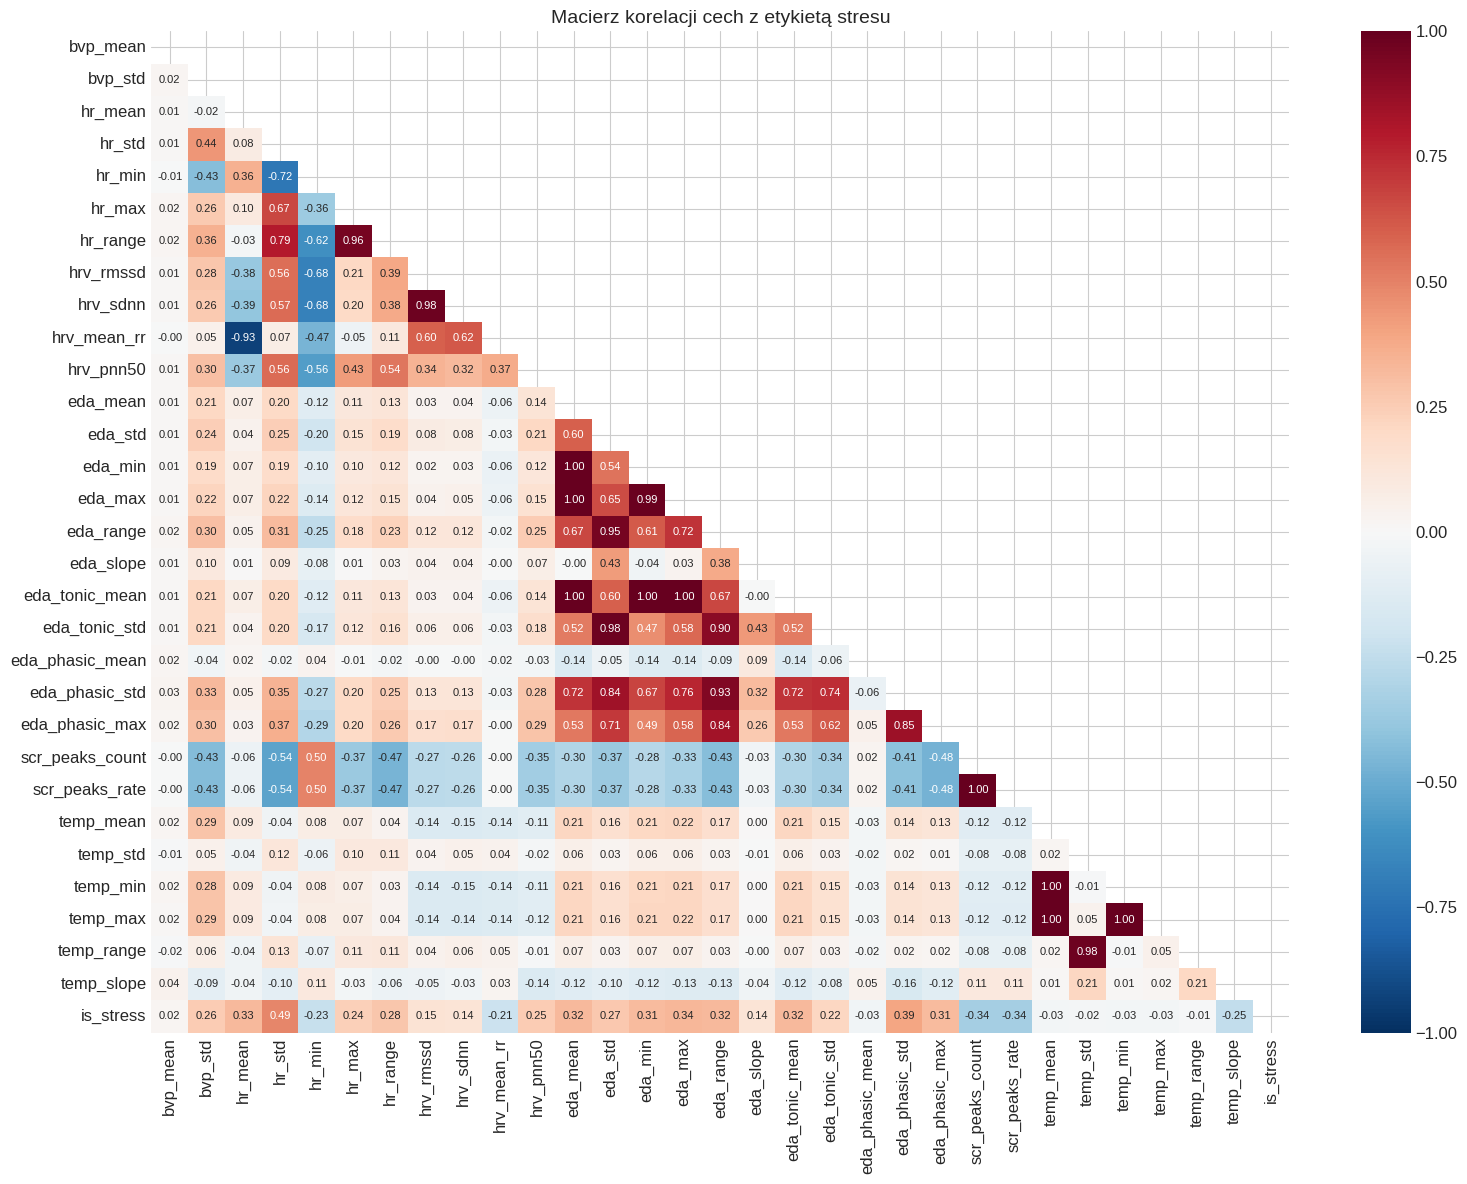


🔥 Korelacja cech ze stresem (top 10):
hr_std             0.488135
eda_phasic_std     0.391782
scr_peaks_rate     0.337291
scr_peaks_count    0.337291
eda_max            0.335292
hr_mean            0.325026
eda_mean           0.323548
eda_tonic_mean     0.323527
eda_range          0.323161
eda_min            0.314269
Name: is_stress, dtype: float64


In [21]:
# Macierz korelacji
plt.figure(figsize=(16, 12))
corr_matrix = df_clean[feature_columns + ['is_stress']].corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r', 
            center=0, vmin=-1, vmax=1, annot_kws={'size': 8})
plt.title('Macierz korelacji cech z etykietą stresu', fontsize=14)
plt.tight_layout()
plt.show()

# Najważniejsze korelacje ze stresem
print("\n🔥 Korelacja cech ze stresem (top 10):")
stress_corr = corr_matrix['is_stress'].drop('is_stress').abs().sort_values(ascending=False)
print(stress_corr.head(10))

## 8. Modelowanie: Random Forest z walidacją LOSO

**LOSO (Leave-One-Subject-Out)** - trenujemy na N-1 uczestnikach, testujemy na 1. 
To pokazuje, czy model generalizuje na nowe osoby!

In [22]:
# Walidacja Leave-One-Subject-Out
logo = LeaveOneGroupOut()

# Model: Random Forest
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        random_state=42,
        n_jobs=-1,
        class_weight='balanced'  # Obsługa niezbalansowanych klas
    ))
])

print("🔄 Walidacja LOSO (Leave-One-Subject-Out)...\n")

# Predykcje cross-validation
y_pred = cross_val_predict(pipeline, X, y, cv=logo, groups=groups, n_jobs=-1)

print("✅ Walidacja zakończona!")

🔄 Walidacja LOSO (Leave-One-Subject-Out)...

✅ Walidacja zakończona!
✅ Walidacja zakończona!


In [23]:
# Wyniki
print("="*60)
print("📊 WYNIKI KLASYFIKACJI: Stres vs Nie-Stres")
print("="*60)
print(f"\n🎯 Accuracy: {accuracy_score(y, y_pred)*100:.2f}%")
print(f"🎯 F1-Score (macro): {f1_score(y, y_pred, average='macro')*100:.2f}%")
print(f"🎯 F1-Score (weighted): {f1_score(y, y_pred, average='weighted')*100:.2f}%")

print("\n" + "="*60)
print("📋 Classification Report:")
print("="*60)
print(classification_report(y, y_pred, target_names=['Nie-Stres', 'Stres']))

📊 WYNIKI KLASYFIKACJI: Stres vs Nie-Stres

🎯 Accuracy: 88.64%
🎯 F1-Score (macro): 81.97%
🎯 F1-Score (weighted): 88.53%

📋 Classification Report:
              precision    recall  f1-score   support

   Nie-Stres       0.92      0.93      0.93      1442
       Stres       0.73      0.69      0.71       362

    accuracy                           0.89      1804
   macro avg       0.83      0.81      0.82      1804
weighted avg       0.88      0.89      0.89      1804



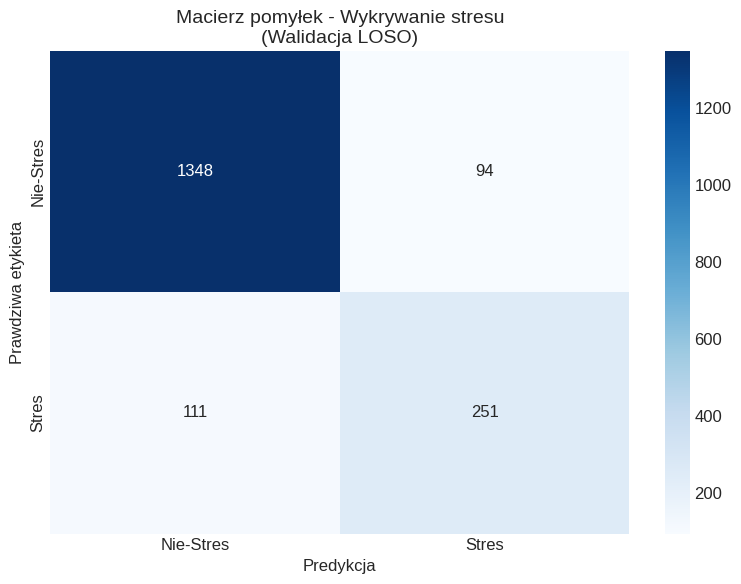


📈 Interpretacja:
   True Negatives (poprawnie: Nie-Stres): 1348
   True Positives (poprawnie: Stres): 251
   False Positives (fałszywy alarm): 94
   False Negatives (pominięty stres): 111

   Sensitivity (Recall dla Stres): 69.3%
   Specificity (Recall dla Nie-Stres): 93.5%


In [24]:
# Macierz pomyłek
cm = confusion_matrix(y, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Nie-Stres', 'Stres'],
            yticklabels=['Nie-Stres', 'Stres'])
plt.xlabel('Predykcja')
plt.ylabel('Prawdziwa etykieta')
plt.title('Macierz pomyłek - Wykrywanie stresu\n(Walidacja LOSO)', fontsize=14)
plt.tight_layout()
plt.show()

# Interpretacja
tn, fp, fn, tp = cm.ravel()
print(f"\n📈 Interpretacja:")
print(f"   True Negatives (poprawnie: Nie-Stres): {tn}")
print(f"   True Positives (poprawnie: Stres): {tp}")
print(f"   False Positives (fałszywy alarm): {fp}")
print(f"   False Negatives (pominięty stres): {fn}")
print(f"\n   Sensitivity (Recall dla Stres): {tp/(tp+fn)*100:.1f}%")
print(f"   Specificity (Recall dla Nie-Stres): {tn/(tn+fp)*100:.1f}%")

## 9. Ważność cech (Feature Importance)

In [25]:
# Trenowanie modelu na całych danych (do analizy ważności cech)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)
rf_model.fit(X_scaled, y)

# Ważność cech
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("🏆 Top 15 najważniejszych cech:")
print(feature_importance.head(15))

🏆 Top 15 najważniejszych cech:
           feature  importance
3           hr_std    0.142571
20  eda_phasic_std    0.066168
2          hr_mean    0.058557
17  eda_tonic_mean    0.053759
15       eda_range    0.053612
27        temp_max    0.047518
21  eda_phasic_max    0.046956
9      hrv_mean_rr    0.045396
14         eda_max    0.041021
26        temp_min    0.037966
8         hrv_sdnn    0.037660
24       temp_mean    0.037566
11        eda_mean    0.037419
13         eda_min    0.036697
12         eda_std    0.035588


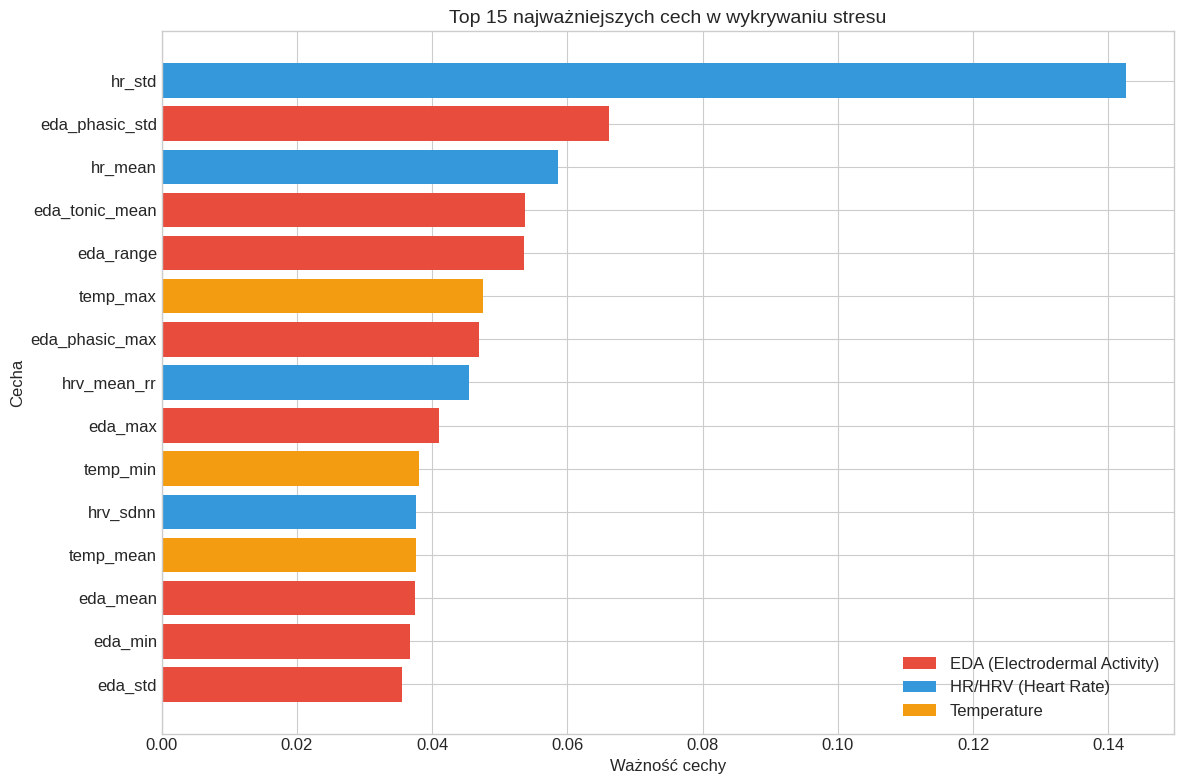

In [26]:
# Wizualizacja ważności cech
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)

colors = ['#e74c3c' if 'eda' in f or 'scr' in f else 
          '#3498db' if 'hr' in f or 'bvp' in f else 
          '#f39c12' for f in top_features['feature']]

bars = plt.barh(top_features['feature'], top_features['importance'], color=colors)
plt.xlabel('Ważność cechy')
plt.ylabel('Cecha')
plt.title('Top 15 najważniejszych cech w wykrywaniu stresu', fontsize=14)
plt.gca().invert_yaxis()

# Legenda kolorów
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#e74c3c', label='EDA (Electrodermal Activity)'),
    Patch(facecolor='#3498db', label='HR/HRV (Heart Rate)'),
    Patch(facecolor='#f39c12', label='Temperature')
]
plt.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()

## 10. Wyniki dla poszczególnych uczestników

In [27]:
# Szczegółowe wyniki per uczestnik
results_per_subject = []

for train_idx, test_idx in logo.split(X, y, groups):
    subject = groups[test_idx[0]]
    y_true_subj = y[test_idx]
    y_pred_subj = y_pred[test_idx]
    
    acc = accuracy_score(y_true_subj, y_pred_subj)
    f1 = f1_score(y_true_subj, y_pred_subj, average='macro', zero_division=0)
    
    results_per_subject.append({
        'Subject': subject,
        'Accuracy': acc,
        'F1-Score': f1,
        'N_samples': len(test_idx),
        'Stress_ratio': y_true_subj.mean()
    })

df_results = pd.DataFrame(results_per_subject)
df_results = df_results.sort_values('Subject')
print("📊 Wyniki dla poszczególnych uczestników:")
print(df_results.to_string(index=False))

print(f"\n📈 Średnia Accuracy: {df_results['Accuracy'].mean()*100:.2f}% (±{df_results['Accuracy'].std()*100:.2f}%)")
print(f"📈 Średni F1-Score: {df_results['F1-Score'].mean()*100:.2f}% (±{df_results['F1-Score'].std()*100:.2f}%)")

📊 Wyniki dla poszczególnych uczestników:
Subject  Accuracy  F1-Score  N_samples  Stress_ratio
    S10  0.919355  0.878336        124      0.209677
    S11  0.867769  0.833333        121      0.206612
    S13  0.918033  0.866052        122      0.196721
    S14  0.801653  0.444954        121      0.198347
    S15  0.851240  0.692025        121      0.206612
    S16  0.966942  0.946318        121      0.198347
    S17  0.793388  0.689457        121      0.214876
     S2  0.938596  0.891738        114      0.201754
     S3  0.852459  0.780048        122      0.196721
     S4  0.950000  0.919319        120      0.191667
     S5  0.890756  0.842223        119      0.193277
     S6  0.882353  0.847324        119      0.201681
     S7  0.872881  0.834192        118      0.194915
     S8  0.883333  0.771242        120      0.208333
     S9  0.909091  0.831881        121      0.190083

📈 Średnia Accuracy: 88.65% (±4.98%)
📈 Średni F1-Score: 80.46% (±12.33%)


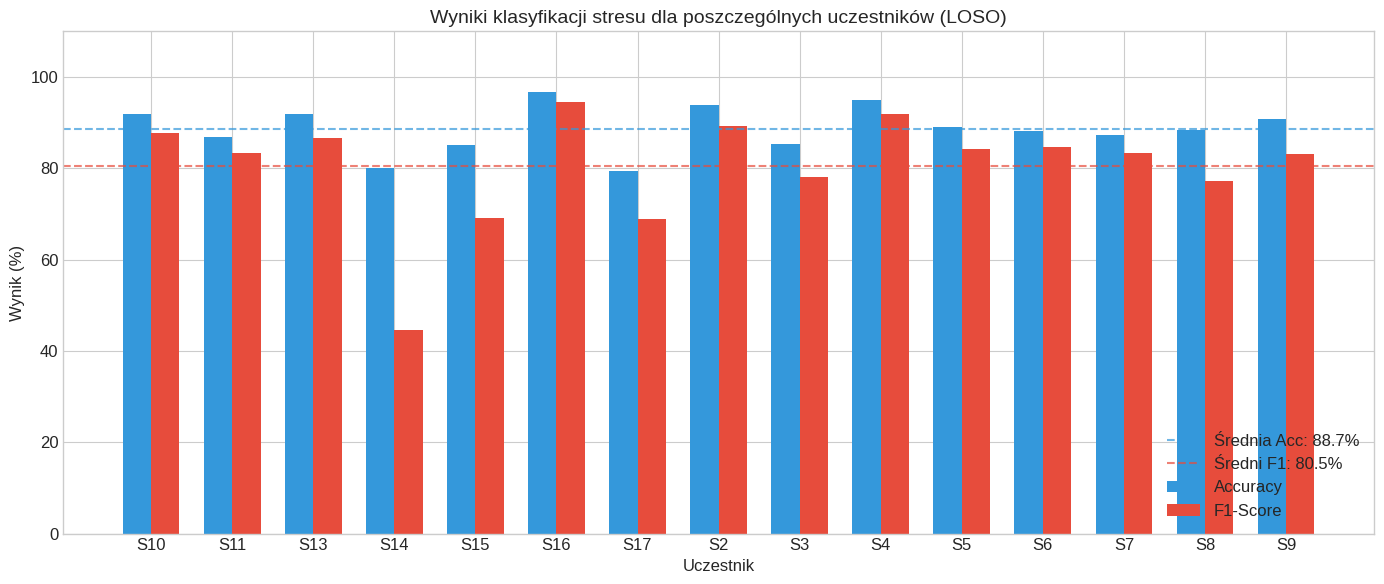

In [28]:
# Wizualizacja wyników per uczestnik
fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(len(df_results))
width = 0.35

bars1 = ax.bar(x - width/2, df_results['Accuracy']*100, width, label='Accuracy', color='#3498db')
bars2 = ax.bar(x + width/2, df_results['F1-Score']*100, width, label='F1-Score', color='#e74c3c')

ax.axhline(y=df_results['Accuracy'].mean()*100, color='#3498db', linestyle='--', alpha=0.7, label=f'Średnia Acc: {df_results["Accuracy"].mean()*100:.1f}%')
ax.axhline(y=df_results['F1-Score'].mean()*100, color='#e74c3c', linestyle='--', alpha=0.7, label=f'Średni F1: {df_results["F1-Score"].mean()*100:.1f}%')

ax.set_xlabel('Uczestnik')
ax.set_ylabel('Wynik (%)')
ax.set_title('Wyniki klasyfikacji stresu dla poszczególnych uczestników (LOSO)', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(df_results['Subject'])
ax.legend(loc='lower right')
ax.set_ylim(0, 110)

plt.tight_layout()
plt.show()

## 11. Podsumowanie i wnioski

In [29]:
print("="*70)
print("📝 PODSUMOWANIE PROJEKTU")
print("="*70)
print(f"""
🎯 CEL: Wykrywanie stresu na podstawie sygnałów fizjologicznych z urządzenia 
        noszonego na nadgarstku (Empatica E4)

📊 DATASET: WESAD (Wearable Stress and Affect Detection)
   - {len(SUBJECTS)} uczestników
   - {len(df_clean)} okien czasowych ({WINDOW_SIZE}s, overlap {WINDOW_SHIFT}s)
   - Sygnały: BVP, EDA, TEMP

🔧 METODOLOGIA:
   - Ekstrakcja {len(feature_columns)} cech z sygnałów (NeuroKit2)
   - Klasyfikator: Random Forest (100 drzew, max_depth=10)
   - Walidacja: Leave-One-Subject-Out (LOSO)

📈 WYNIKI:
   - Accuracy: {accuracy_score(y, y_pred)*100:.2f}%
   - F1-Score (macro): {f1_score(y, y_pred, average='macro')*100:.2f}%
   - Sensitivity (wykrywanie stresu): {tp/(tp+fn)*100:.1f}%
   - Specificity (wykrywanie nie-stresu): {tn/(tn+fp)*100:.1f}%

🏆 TOP 5 NAJWAŻNIEJSZYCH CECH:
""")

for i, row in feature_importance.head(5).iterrows():
    print(f"   {feature_importance.head(5).index.tolist().index(i)+1}. {row['feature']}: {row['importance']:.3f}")

print(f"""
💡 WNIOSKI:
   1. Model skutecznie rozróżnia stany stresu od stanów neutralnych
   2. Cechy HRV (RMSSD, SDNN) są kluczowe dla wykrywania stresu
   3. Sygnał EDA (poty skóry) dostarcza istotnych informacji o pobudzeniu
   4. Walidacja LOSO pokazuje generalizację na nowych użytkowników

🚀 MOŻLIWE ROZSZERZENIA:
   - Użycie deep learning (1D-CNN, LSTM)
   - Dodanie cech z akcelerometru (ruch)
   - Klasyfikacja wieloklasowa (stres vs relaks vs rozrywka)
   - Transfer learning na dane z innych wearables
""")
print("="*70)

📝 PODSUMOWANIE PROJEKTU

🎯 CEL: Wykrywanie stresu na podstawie sygnałów fizjologicznych z urządzenia 
        noszonego na nadgarstku (Empatica E4)

📊 DATASET: WESAD (Wearable Stress and Affect Detection)
   - 15 uczestników
   - 1804 okien czasowych (60s, overlap 30s)
   - Sygnały: BVP, EDA, TEMP

🔧 METODOLOGIA:
   - Ekstrakcja 30 cech z sygnałów (NeuroKit2)
   - Klasyfikator: Random Forest (100 drzew, max_depth=10)
   - Walidacja: Leave-One-Subject-Out (LOSO)

📈 WYNIKI:
   - Accuracy: 88.64%
   - F1-Score (macro): 81.97%
   - Sensitivity (wykrywanie stresu): 69.3%
   - Specificity (wykrywanie nie-stresu): 93.5%

🏆 TOP 5 NAJWAŻNIEJSZYCH CECH:

   1. hr_std: 0.143
   2. eda_phasic_std: 0.066
   3. hr_mean: 0.059
   4. eda_tonic_mean: 0.054
   5. eda_range: 0.054

💡 WNIOSKI:
   1. Model skutecznie rozróżnia stany stresu od stanów neutralnych
   2. Cechy HRV (RMSSD, SDNN) są kluczowe dla wykrywania stresu
   3. Sygnał EDA (poty skóry) dostarcza istotnych informacji o pobudzeniu
   4. Wal

## 12. Zapis modelu i danych

In [30]:
# Zapis przetworzonego datasetu
output_path = Path("/home/milosz/Desktop/studia/afektywna")

df_clean.to_csv(output_path / 'wesad_features.csv', index=False)
print(f"✅ Dataset zapisany: {output_path / 'wesad_features.csv'}")

# Zapis modelu
import joblib
joblib.dump(pipeline, output_path / 'stress_detection_model.joblib')
print(f"✅ Model zapisany: {output_path / 'stress_detection_model.joblib'}")

# Zapis wyników
df_results.to_csv(output_path / 'loso_results.csv', index=False)
print(f"✅ Wyniki zapisane: {output_path / 'loso_results.csv'}")

✅ Dataset zapisany: /home/milosz/Desktop/studia/afektywna/wesad_features.csv
✅ Model zapisany: /home/milosz/Desktop/studia/afektywna/stress_detection_model.joblib
✅ Wyniki zapisane: /home/milosz/Desktop/studia/afektywna/loso_results.csv


---

## 📚 Bibliografia

1. **WESAD Dataset:** Schmidt, P., et al. (2018). "Introducing WESAD, a Multimodal Dataset for Wearable Stress and Affect Detection." ICMI 2018.

2. **NeuroKit2:** Makowski, D., et al. (2021). "NeuroKit2: A Python toolbox for neurophysiological signal processing."

3. **HRV Analysis:** Shaffer, F., & Ginsberg, J. P. (2017). "An overview of heart rate variability metrics and norms."

4. **EDA Processing:** Benedek, M., & Kaernbach, C. (2010). "A continuous measure of phasic electrodermal activity."

---

**Autor:** [Twoje imię]

**Data:** Grudzień 2025

**Przedmiot:** Informatyka Afektywna